In [23]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

## 1) Data Process

In [24]:
dataset = pd.read_csv('cloth.csv', error_bad_lines = False, encoding='utf-8-sig', engine = 'python')
dataset.columns

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['订单编号', '订单状态', '下单时间', '支付时间', '发货时间', '商品型号', '商品件数', '商品ID',
       'SKU ID'],
      dtype='object')

In [25]:
# dataset = dataset[dataset['订单状态'] != '已关闭']
datetime.strptime('11/13/2022 20:44', '%m/%d/%Y %H:%M')
dataset['下单时间'] = dataset['下单时间'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'))
# dataset['支付时间'] = dataset['支付时间'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M'))
# dataset['发货时间'] = dataset['发货时间'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M') if not pd.isnull(x) else x)
dataset['minute'] = dataset['下单时间'].apply(lambda x: (x - dataset.iloc[-1]['下单时间']) / pd.Timedelta(1, "m"))

In [26]:
dataset

,订单编号,订单状态,下单时间,支付时间,发货时间,商品型号,商品件数,商品ID,SKU ID,minute
0,819699396876564,待发货,2022-11-13 20:44:00,11/13/2022 20:45,NaN,桃木褐36号,1,5730170770,85770385839,27404.0
1,819699012788048,已发货,2022-11-13 20:43:00,11/13/2022 20:43,11/15/2022 19:06,狐狸灰36号,1,5730170770,85770539838,27403.0
2,819698748969658,已关闭,2022-11-13 20:03:00,NaN,NaN,桃木褐34号,1,5730170770,85770385837,27363.0
3,819698079600420,已发货,2022-11-13 18:54:00,11/13/2022 18:55,11/14/2022 13:07,狐狸灰36号,1,5730170770,85770539838,27294.0
4,819698112155428,已发货,2022-11-13 18:47:00,11/13/2022 18:48,11/14/2022 13:07,桃木褐34号,1,5730170770,85770385837,27287.0
...,...,...,...,...,...,...,...,...,...,...
1068,819370390354858,已完成,2022-10-25 20:00:00,10/25/2022 20:00,10/26/2022 14:45,狐狸灰32号,1,5730170770,85770539834,0.0
1069,819370196497581,已完成,2022-10-25 20:00:00,10/25/2022 20:00,10/27/2022 9:45,狐狸灰34号,1,5730170770,85770539836,0.0
1070,819378487646430,已发货,2022-10-25 20:00:00,10/25/2022 20:00,10/27/2022 10:01,桃木褐34号,1,5730170770,85770385837,0.0
1071,819370325276251,已完成,2022-10-25 20:00:00,10/25/2022 20:00,10/27/2022 9:36,狐狸灰32号,1,5730170770,85770539834,0.0


In [27]:
dataset.rename(columns = {'订单编号': 'Order_no', '订单状态': 'Order_status', '下单时间': 'Order_time', '支付时间':'Payment_time', '发货时间': 'Shipping_time', '商品型号': 'Size', '商品件数': 'Product_no', '商品ID': 'Product_id', 'SKU ID': 'SKU_id', 'minute': 'Minute'}).head()

,Order_no,Order_status,Order_time,Payment_time,Shipping_time,Size,Product_no,Product_id,SKU_id,Minute
0,819699396876564,待发货,2022-11-13 20:44:00,11/13/2022 20:45,NaN,桃木褐36号,1,5730170770,85770385839,27404.0
1,819699012788048,已发货,2022-11-13 20:43:00,11/13/2022 20:43,11/15/2022 19:06,狐狸灰36号,1,5730170770,85770539838,27403.0
2,819698748969658,已关闭,2022-11-13 20:03:00,NaN,NaN,桃木褐34号,1,5730170770,85770385837,27363.0
3,819698079600420,已发货,2022-11-13 18:54:00,11/13/2022 18:55,11/14/2022 13:07,狐狸灰36号,1,5730170770,85770539838,27294.0
4,819698112155428,已发货,2022-11-13 18:47:00,11/13/2022 18:48,11/14/2022 13:07,桃木褐34号,1,5730170770,85770385837,27287.0


## 2) Cumulative Purchases in Real Dataset

In [28]:
countPerMinute = dict()
for i in dataset['minute']:
    if i not in countPerMinute:
        countPerMinute[i] = 1
    else:
        countPerMinute[i] += 1

In [29]:
purchase_track = []
sorted_lst = sorted(list((i, countPerMinute[i]) for i in countPerMinute))
for i in range(len(sorted_lst)):
    if len(purchase_track) == 0:
        purchase_track.append(sorted_lst[i])
    else:
        purchase_track.append((sorted_lst[i][0],sum([j[1] for j in sorted_lst[:i + 1]])))
purchase_track

[(0.0, 493),
 (1.0, 538),
 (2.0, 556),
 (3.0, 567),
 (4.0, 575),
 (5.0, 578),
 (6.0, 581),
 (7.0, 584),
 (8.0, 586),
 (9.0, 594),
 (11.0, 601),
 (12.0, 603),
 (13.0, 604),
 (15.0, 606),
 (16.0, 614),
 (17.0, 620),
 (18.0, 622),
 (19.0, 623),
 (20.0, 624),
 (25.0, 625),
 (33.0, 626),
 (45.0, 627),
 (47.0, 628),
 (56.0, 629),
 (58.0, 631),
 (59.0, 634),
 (62.0, 635),
 (129.0, 636),
 (138.0, 637),
 (2525.0, 639),
 (2526.0, 640),
 (2528.0, 649),
 (2529.0, 652),
 (2530.0, 654),
 (2531.0, 656),
 (2532.0, 658),
 (2533.0, 661),
 (2534.0, 662),
 (2536.0, 663),
 (2540.0, 664),
 (2561.0, 665),
 (2577.0, 666),
 (2580.0, 667),
 (2589.0, 668),
 (2593.0, 670),
 (2594.0, 671),
 (2623.0, 672),
 (3914.0, 682),
 (3915.0, 687),
 (3916.0, 691),
 (3917.0, 692),
 (3919.0, 693),
 (3920.0, 695),
 (3924.0, 696),
 (3927.0, 698),
 (3928.0, 699),
 (3931.0, 700),
 (3935.0, 701),
 (3940.0, 702),
 (3954.0, 703),
 (4050.0, 704),
 (4060.0, 705),
 (4082.0, 706),
 (4108.0, 707),
 (4178.0, 708),
 (4186.0, 709),
 (4210.0, 

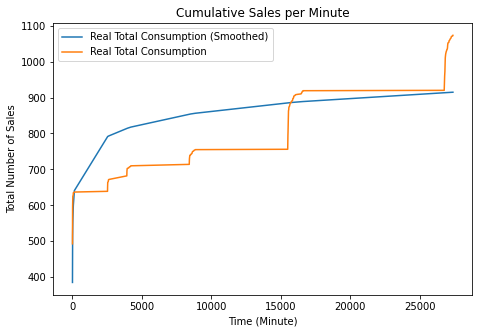

In [45]:
x = [i[0] + 1 for i in purchase_track]
y_real = [i[1] for i in purchase_track]
plt.figure(figsize=(7.5, 5))
para = np.polyfit(np.log(x), y_real, 1)
y_new = [para[0] * np.log(i) + para[1] for i in x]
plt.plot(x, y_new)
plt.plot(x,y_real)
plt.title('Cumulative Sales per Minute')
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Real Total Consumption (Smoothed)', 'Real Total Consumption'])
plt.show()

## 3) Parameter Simulation

In [101]:
def MAE(sim, real):
    return sum([abs(i - j) for i, j in zip(sim, real)])/len(sim)
def parameter_search(beta, alpha, mu, S20, S10, I0 = 1, duration = 27405):
    # Total population, N.
    N = S10 + S20 + 1
    # Initial number of infected and recovered individuals, I0.
    I0 = I0

    # rate per minute
    beta, alpha, mu
    # A grid of time points (in minute)
    t = np.linspace(0, duration, duration)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, alpha, mu):
        S1, S2, I = y
        dS1dt = -beta * S1 + mu * S1 * I / N
        dS2dt = -(beta + alpha) * S2 + mu * S2 * I / N
        dIdt = beta * S1 + (alpha + beta) * S2 - mu * S1 * I / N - mu * S2 * I / N
        return dS1dt, dS2dt, dIdt

    # Initial conditions vector
    y0 = S10, S20, I0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, alpha, mu))
    S1, S2, I = ret.T
    S = S1 + S2
    purchase_history = [S1[i] * beta + S2[i] * (beta + alpha) for i in range(len(S1))]

    purchase_historys1 = [S1[i] * beta for i in range(len(S1))]
    purchase_historys2 = [S2[i] * (beta + alpha) for i in range(len(S1))]
    purchase_count = np.cumsum(purchase_history)
    purchase_count1 = np.cumsum(purchase_historys1)
    purchase_count2 = np.cumsum(purchase_historys2)
    print(f'alpha: {alpha}, beta: {beta}, mu: {mu}, S10 : {S10}, S20: {S20}')
    # print('MAE: ' + str(MAE(y_real, purchase_count)))
    return I, purchase_count, purchase_count1, purchase_count2, S1, S2

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600


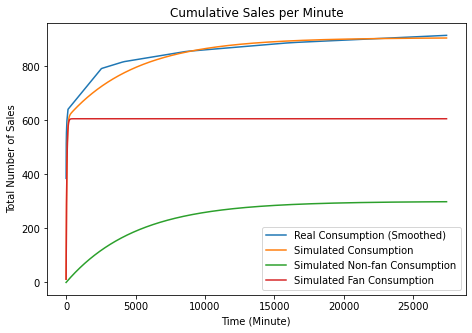

In [102]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
plt.figure(figsize=(7.5, 5))
x = [i[0] + 1 for i in purchase_track]
y = [i[1] for i in purchase_track]
para = np.polyfit(np.log(x), y, 1)
plt.plot(x, y_new)
x = parameter_search(beta, alpha, mu, 600, 300)
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Real Consumption (Smoothed)', 'Simulated Consumption', 'Simulated Non-fan Consumption', 'Simulated Fan Consumption'])
plt.title('Cumulative Sales per Minute')
plt.show()

## 4) Different Social Media Influencers' Effect on the Coat

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600


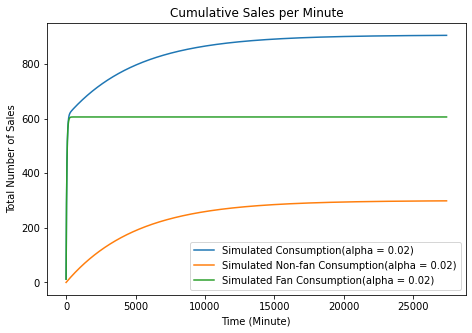

alpha: 0.2, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600


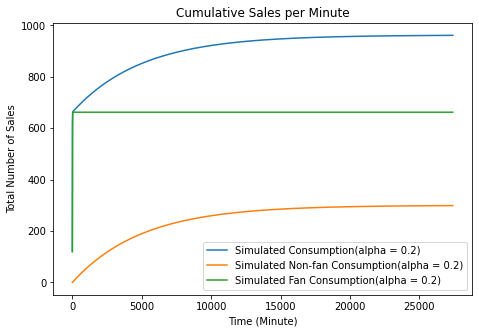

In [103]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
plt.figure(figsize=(7.5, 5))
x = parameter_search(beta, alpha, mu, 600, 300)
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(alpha = 0.02)', 'Simulated Non-fan Consumption(alpha = 0.02)', 'Simulated Fan Consumption(alpha = 0.02)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha, beta, mu = (0.2, 0.0002, 0.0000001)
x = parameter_search(beta, alpha, mu, 600, 300)
plt.figure(figsize=(7.5, 5))
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(alpha = 0.2)', 'Simulated Non-fan Consumption(alpha = 0.2)', 'Simulated Fan Consumption(alpha = 0.2)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600
alpha: 0.2, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600


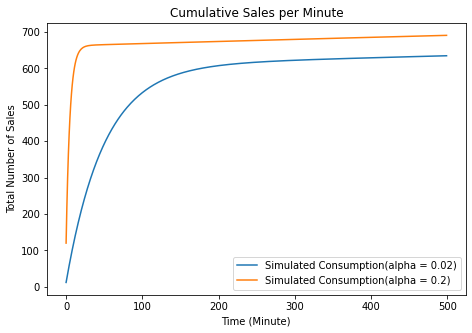

In [104]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
x = parameter_search(beta, alpha, mu, 600, 300)
alpha, beta, mu = (0.2, 0.0002, 0.0000001)
y = parameter_search(beta, alpha, mu, 600, 300)
plt.figure(figsize=(7.5, 5))
plt.plot(x[1][:500])
plt.plot(y[1][:500])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(alpha = 0.02)', 'Simulated Consumption(alpha = 0.2)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600
904.9494417697864


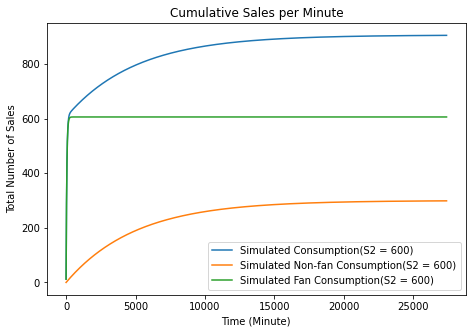

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 1200
1511.019046995845


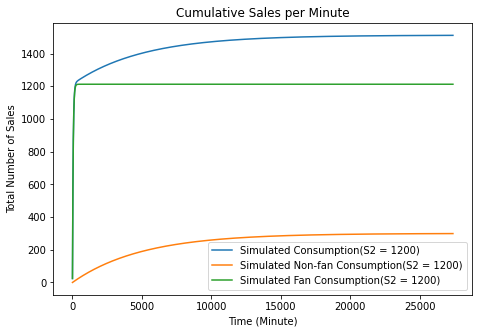

In [105]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
plt.figure(figsize=(7.5, 5))
x = parameter_search(beta, alpha, mu, 600, 300)
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
print(x[1][-1])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(S2 = 600)', 'Simulated Non-fan Consumption(S2 = 600)', 'Simulated Fan Consumption(S2 = 600)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha, beta, mu = (0.02, 0.0002, 0.0000001)
x = parameter_search(beta, alpha, mu, 1200, 300)
plt.figure(figsize=(7.5, 5))
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
print(x[1][-1])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(S2 = 1200)', 'Simulated Non-fan Consumption(S2 = 1200)', 'Simulated Fan Consumption(S2 = 1200)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 600
alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 1200


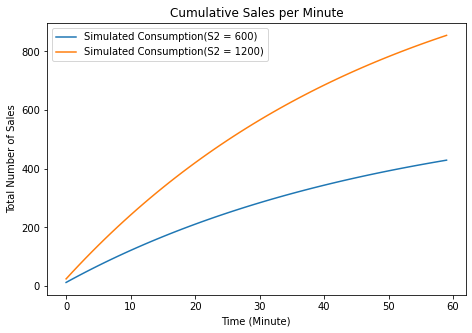

In [118]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
x = parameter_search(beta, alpha, mu, 600, 300)
y = parameter_search(beta, alpha, mu, 1200, 300)
plt.figure(figsize=(7.5, 5))
plt.plot(x[1][:60])
plt.plot(y[1][:60])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(S2 = 600)', 'Simulated Consumption(S2 = 1200)'])
plt.title('Cumulative Sales per Minute')
plt.show()

alpha: 0.02, beta: 0.0002, mu: 1e-07, S10 : 300, S20: 0
300.1052186959729


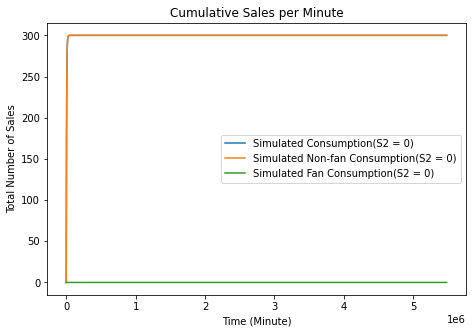

In [109]:
alpha, beta, mu = (0.02, 0.0002, 0.0000001)
x = parameter_search(beta, alpha, mu, 0, 300, duration = 27405 * 200)
plt.figure(figsize=(7.5, 5))
plt.plot(x[1])
plt.plot(x[2])
plt.plot(x[3])
print(x[1][-1])
plt.xlabel('Time (Minute)')
plt.ylabel('Total Number of Sales')
plt.legend(['Simulated Consumption(S2 = 0)', 'Simulated Non-fan Consumption(S2 = 0)', 'Simulated Fan Consumption(S2 = 0)'])
plt.title('Cumulative Sales per Minute')
plt.show()